<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Tver_elastisity_preprocess_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [ ]:
path_to_ser = Path('/content/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

,#,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water
30,129897,129897,b,"выбоины, трещины",23.648542,1426.840000,2.075533,2.078293,2.212333,1.503667,3.167705,1.861495,3.2595,1.7465
31,129913,129913,b,"пористо-кавернозный, большие каверны",10.171065,119.017000,2.433178,2.425019,4.072333,2.521333,5.099085,2.699025,4.9965,2.5820
32,129914,129914,b,"пористо-кавернозный, на торцах присутствуют бо...",5.877850,0.491424,2.498266,2.536095,5.013000,2.883000,5.491510,2.945640,5.4025,2.9025
33,129937,129937,b,пористо-кавернозный,12.718631,64.508600,2.374723,2.364644,3.926333,2.342333,4.469470,2.513400,4.5515,2.3585


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Vp/Vs air
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN


In [ ]:
data[['Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil', 'Vs oil']].describe()

,Vp air,Vs air,Vp water,Vs water,Vp oil,Vs oil
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.049354,2.347747,4.734121,2.500788,4.801224,2.647978
std,0.785375,0.394807,0.634691,0.349465,0.684056,0.374006
min,2.212333,1.323000,3.259500,1.718500,3.167705,1.825235
25%,3.514333,2.076667,4.405000,2.233000,4.224880,2.373170
50%,4.042333,2.360000,4.900000,2.582000,4.972040,2.704390
75%,4.839333,2.675000,5.211500,2.723500,5.190400,2.876360
max,5.199333,2.883000,5.674000,2.991500,5.958540,3.269995


In [ ]:
data['Vp/Vs air'] = data[['Vp air', 'Vs air']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs water'] = data[['Vp water', 'Vs water']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs oil'] = data[['Vp oil', 'Vs oil']].apply(lambda x: x[0]/x[1], axis=1)

data['Vp Water/Oil Diff'] = data[['Vp water', 'Vp oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)
data['Vs Water/Oil Diff'] = data[['Vs water', 'Vs oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [ ]:
    ### Moduli Air
data['K air'] = data[['Vp air', 'Vs air', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu air'] = data[['Vs air', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Water
data['K water'] = data[['Vp water', 'Vs water', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu water'] = data[['Vs water', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Oil
data['K oil'] = data[['Vp oil', 'Vs oil', 'Density (oil)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu oil'] = data[['Vs oil', 'Density (oil)']].apply(lambda x: x[1] * x[0]**2, axis=1)

In [ ]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Vp/Vs air,Vp/Vs water,Vp/Vs oil,Vp Water/Oil Diff,Vs Water/Oil Diff,K air,Mu air,K water,Mu water,K oil,Mu oil
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,2.134322,1.998302,1.842867,-4.85,-12.25,46.159570,14.326384,48.028807,18.056785,48.450587,23.487506
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,1.665111,1.896623,1.815870,-2.30,-6.46,21.521152,14.952932,40.793349,18.019497,40.324913,20.531503
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,1.759806,1.804075,1.818652,-1.82,-1.03,16.072570,9.113578,21.893623,11.394892,23.087306,11.694747
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,1.763650,1.880947,1.834958,-3.92,-6.27,13.959632,7.855171,21.101203,9.571328,22.092591,10.863045
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,1.625910,1.928486,1.855972,1.41,-2.40,17.592209,13.426620,36.765377,15.410573,33.965842,16.087646


In [ ]:
data[['Vp Water/Oil Diff', 'Vs Water/Oil Diff']].describe()

,Vp Water/Oil Diff,Vs Water/Oil Diff
count,33.000000,33.000000
mean,-1.018788,-5.234242
std,7.620490,8.221110
min,-21.120000,-24.470000
25%,-4.850000,-10.100000
50%,-1.770000,-6.180000
75%,1.840000,-2.400000
max,31.430000,25.300000


Text(0, 0.5, 'Absolute Percentage Error, %')

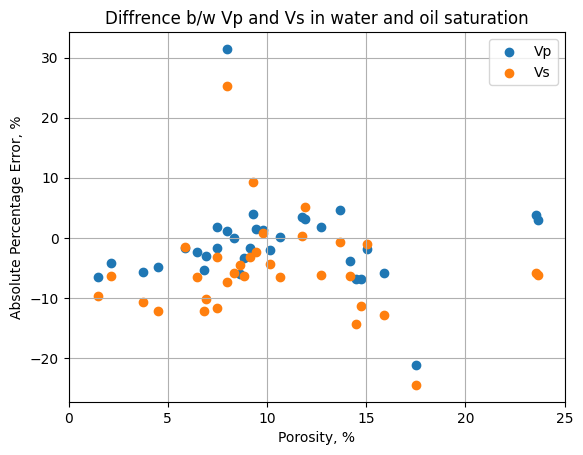

In [ ]:
plt.scatter(data['Porosity,%'], data['Vp Water/Oil Diff'], label='Vp')
plt.scatter(data['Porosity,%'], data['Vs Water/Oil Diff'], label='Vs')
plt.title('Diffrence b/w Vp and Vs in water and oil saturation')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

$Susan, 1992$
https://www.crewes.org/Documents/ResearchReports/1992/1992-12.pdf

https://www.researchgate.net/publication/249866305_Changes_in_dynamic_shear_moduli_of_carbonate_rocks_with_fluid_substitution

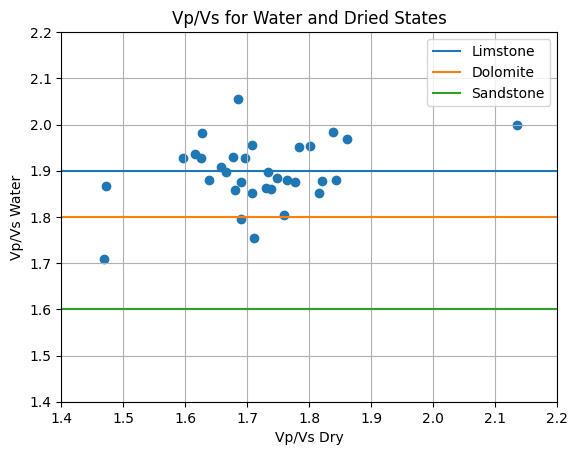

In [ ]:
plt.scatter(data['Vp/Vs air'], data['Vp/Vs water'])
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
plt.xlim(1.4, 2.2)
plt.ylim(1.4, 2.2)
plt.title('Vp/Vs for Water and Dried States')
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

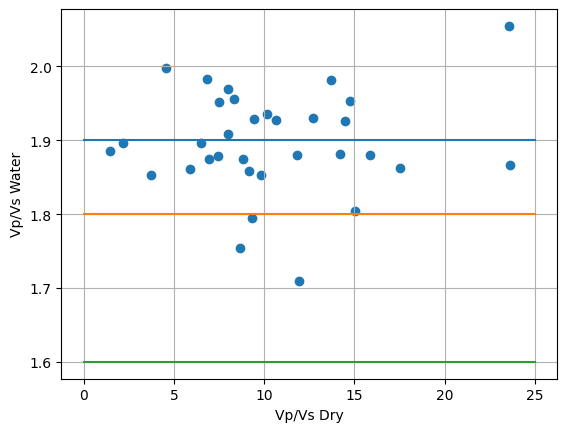

In [ ]:
# plt.scatter(data['Porosity,%'], data['Vp/Vs air'], label='air')
plt.scatter(data['Porosity,%'], data['Vp/Vs water'], label='air')
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.grid()

### Vp, Vs, density of minerals
- Calcite Peselnick and Robie (1963) Vp=6.54 Vs=3.35, p=2.71
- Dolomite Ahrens (1995) Vp=6.40; Vs=3.46 p=2.86

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [ ]:
### Calcite
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])

### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [ ]:
K_calcite, mu_calcite

(75.36040266666667, 30.412975)

In [ ]:
K_dolomite, mu_dolomite

(71.49389866666668, 34.238776)

In [ ]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [ ]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
K_matrix, Mu_matrix = K_calcite, mu_calcite

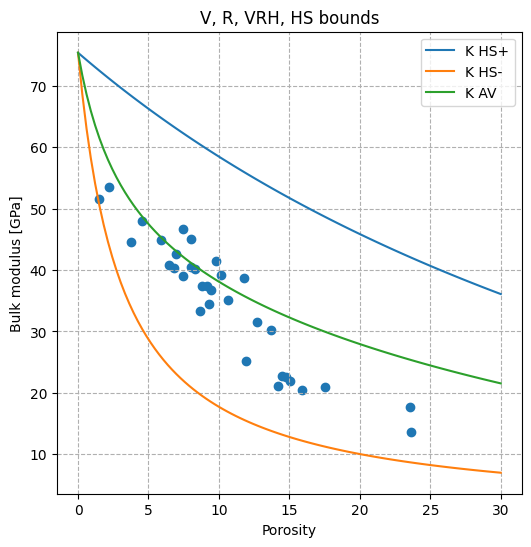

In [ ]:
porosity = np.linspace(0, 0.3, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)



plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('HS bounds - Water')

plt.plot(porosity*100, K_up_value,label='K HS+')
plt.plot(porosity*100, K_lo_value,label='K HS-')
plt.plot(porosity*100, K_av_value,label='K AV')

plt.scatter(data['Porosity,%'], data['K water'])

plt.legend(loc='best')
plt.grid(ls='--')

HS bourders for K and Mu moduli in diffrent saturation states.
--> All samples are inside bourdes for which Calcite moduli K and mu were used.

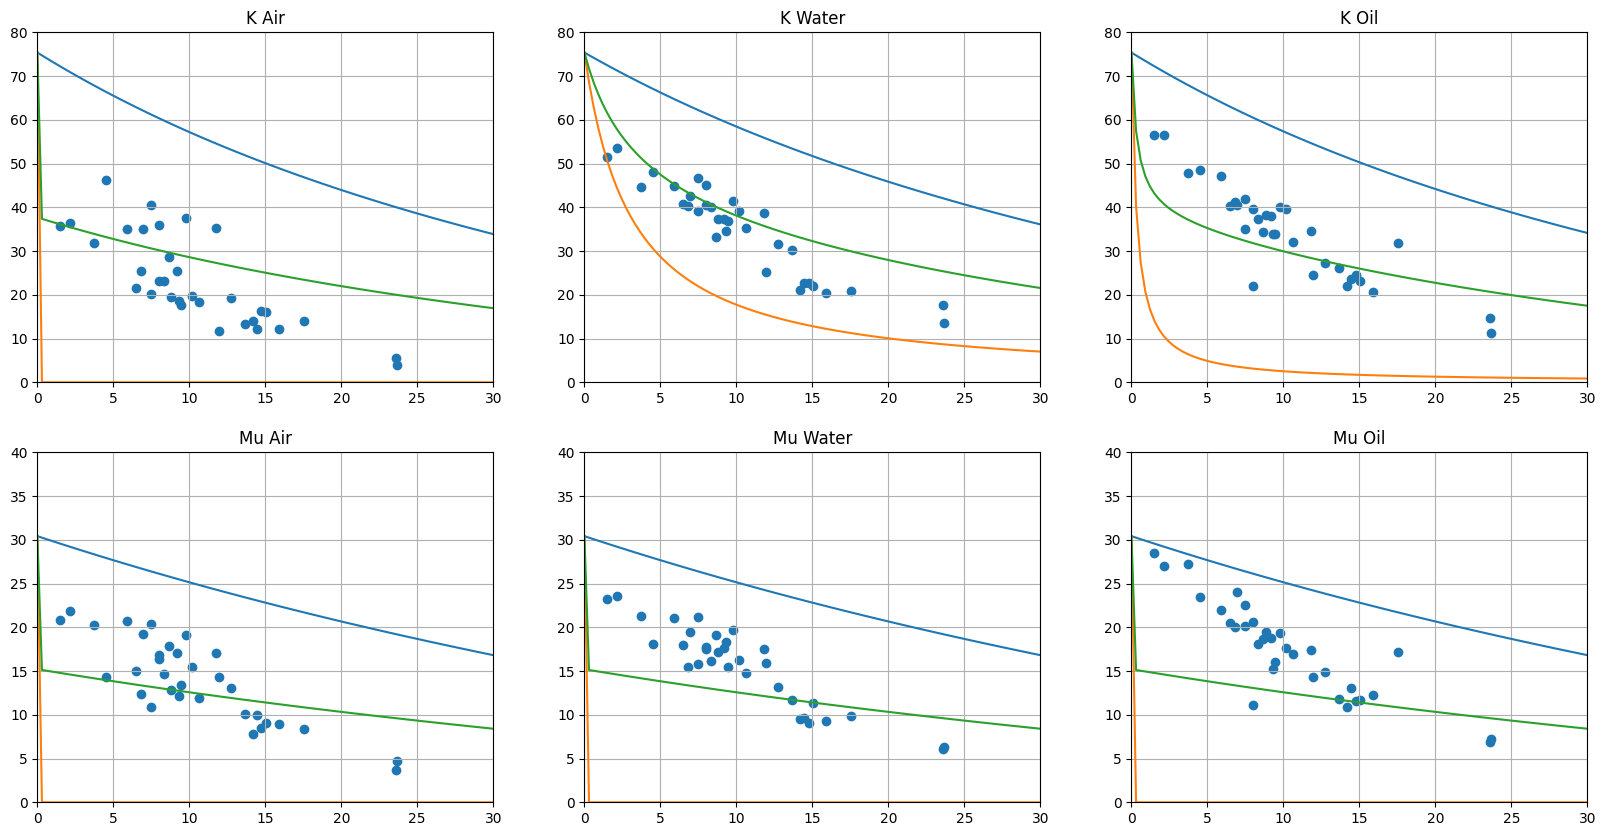

In [ ]:
fig = plt.figure(figsize=(20, 10))

porosity = np.linspace(0, 0.3, 100, endpoint=True)

K_matrix, Mu_matrix = K_calcite, mu_calcite

MODULI = {
    "K Air": [data['K air'], K_matrix, K_air, Mu_matrix, Mu_air],
    "K Water":[data['K water'], K_matrix, K_water, Mu_matrix, Mu_water],
    "K Oil" : [data['K oil'],K_matrix, K_oil, Mu_matrix, Mu_oil],
    "Mu Air" : [data['Mu air'], K_matrix, K_air, Mu_matrix, Mu_air],
     "Mu Water" : [data['Mu water'], K_matrix, K_water, Mu_matrix, Mu_water],
     "Mu Oil" : [data['Mu oil'], K_matrix, K_oil, Mu_matrix, Mu_oil]
}

for index, (name, moduli) in enumerate(MODULI.items()):

  K_matrix, K_fluid, Mu_matrix, Mu_fluid = moduli[1], moduli[2], moduli[3], moduli[4]

  K_up_value, K_lo_value, K_av_value = [], [], []
  Mu_up_value, Mu_lo_value, Mu_av_value = [], [], []

  for phi in porosity:
    K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
    K_up, K_lo, K_av, Mu_up, Mu_lo, Mu_av  = HS_borders(K, μ, f)

    K_up_value.append(K_up)
    K_lo_value.append(K_lo)
    K_av_value.append(K_av)

    Mu_up_value.append(Mu_up)
    Mu_lo_value.append(Mu_lo)
    Mu_av_value.append(Mu_av)


  ax = plt.subplot(2, 3, index + 1)
  plt.scatter(data['Porosity,%'], moduli[0])

  if index < 3: ### K moduli (upper plots)
    plt.plot(porosity*100, K_up_value,label='K HS+')
    plt.plot(porosity*100, K_lo_value,label='K HS-')
    plt.plot(porosity*100, K_av_value,label='K AV')
    plt.ylim(0, 80)

  else: ### Mu moduli (bottom plots)
    plt.plot(porosity*100, Mu_up_value,label='K HS+')
    plt.plot(porosity*100, Mu_lo_value,label='K HS-')
    plt.plot(porosity*100, Mu_av_value,label='K AV')
    plt.ylim(0, 40)

  plt.grid()
  plt.xlim(0, 30)
  plt.title(f'{name}')

### GSA isotropic

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

### Нотация Фойта - переход к матричной записи

In [2]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.empty((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

### Input data

In [3]:
# M_C11 = K_matrix + 4/3*Mu_matrix
# M_C44 = Mu_matrix
# M_C12 = M_C11 - 2*M_C44

M_C11 = 80
M_C44 = 36
M_C12 = M_C11 - 2*M_C44


C_mtrx = np.zeros((6,6))
C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

C_mtrx = mat2tens(C_mtrx, compl=False)
C_c = C_mtrx


# k, mu = K_air, Mu_air
k, mu = 2.25, 10**-6

lambda_ = k - 2 * mu / 3
c11 = lambda_ + 2 * mu
c12 = lambda_
c44 = mu

Fl_C11 = c11
Fl_C12 = c12
Fl_C44 = (Fl_C11 - Fl_C12)*0.5

C_fl = np.zeros((6, 6))
C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

C_fl = mat2tens(C_fl, compl=False)

Tensor $g_{ijkl}$ calculation

In [4]:
pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

In [5]:
g_matrix = tensor_g(C_c, [1,1,1])

In [6]:
g_fluid = tensor_g(C_c, [1000,1000,1])

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


### Result rotation for the whole medium (Shermergor isotropic case)

Поворот тензора упругости на этапе, когда он полностью рассчитан

In [ ]:
def rotation_shermergor(theta, phi, psi, Cij, position):

  c11, c12, c44 = Cij[0], Cij[1], Cij[2]
  i,j,k,l = int(position[0]), int(position[1]), int(position[2]), int(position[3])

  c1, c2, c3 = np.cos(theta), np.cos(psi), np.cos(phi)
  s1, s2, s3 = np.sin(theta), np.sin(psi), np.sin(phi)

  l1 = c2*c3 - c1*s2*s3
  l2 = -c2*s3 - c1*s2*c3
  l3 = s1*s2

  m1 = s2*c3 + c1*c2*s3
  m2 = -s2*s3 + c1*c2*c3
  m3 = -s1*c2

  n1 = s1*s3
  n2 = s1*c3
  n3 = c1

  c = c11 - c12 - 2*c44

  c11_new = c11 - 2*c*(l1**2*m1**2 + m1**2*n1**2 + n1**2*l1**2)
  c12_new = c12 + c*(l1**2*l2**2 + m1**2*m2**2 + n1**2*n2**2)
  c44_new = c44 + c*(l2**2*l3**2 + m2**2*m3**2 + n2**2*n3**2)

  C_new = np.zeros((6, 6))
  C_new[0,0] = C_new[1, 1] = C_new[2,2] = c11_new

  C_new[0,1] = C_new[0,2] = C_new[1,0] = C_new[1,2] = C_new[2,0] = C_new[2,1] = c12_new
  C_new[3,3] = C_new[4,4] = C_new[5,5] = c44_new

  A_new = mat2tens(C_new, compl=False)

  return A_new[i,j,k,l]

In [ ]:
def effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))

  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)

  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  ### -----------

  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*num_fl)

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)
  result_fl = (x_fl1 @ g_inv_fl1) * porosity
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)


        ### Effective Cij
  effective_total = rslt_num @ rslt_dnmntr
  print(np.round(effective_total, 3))

  new_eff = np.zeros((3,3,3,3))
  V = 8*np.pi**2 ### нормировка

  for i in range(3):
    for j in range(3):
      for k in range(3):
        for l in range(3):

          A =  effective_total

          Cij = [A[0,0], A[0,1], A[3,3]]

          integrand = (lambda theta, phi, psi, i=i, j=j, k=k, l=l: rotation_shermergor(theta, phi, psi, Cij,(i,j,k,l))* np.sin(theta))
          integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
          new_eff[i, j, k, l] =  integral/V

  result = tens2mat(new_eff, compl=False) ### тензор повернутый в систему XYZ
  print(np.round(result, 3))

  return result[0,0], result[0,2], result[3,3]

In [ ]:
effective_tensor_new(g_matrix, g_fluid, C_mtrx, C_fl, C_c, 0.1)

[[71.883  7.17   3.845 -0.     0.    -0.   ]
 [ 7.17  71.883  3.845 -0.     0.    -0.   ]
 [ 3.845  3.845 20.992 -0.     0.    -0.   ]
 [-0.    -0.    -0.     4.576  0.     0.   ]
 [ 0.     0.     0.     0.     4.576  0.   ]
 [-0.    -0.    -0.     0.     0.    32.356]]


KeyboardInterrupt: 

In [ ]:
c11, c12, c44 = [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = 4.52/100

AR = np.linspace(1, 1000, 20)

g_m = tensor_g(C_c, [1, 1, 1])

for i in AR:

  g_fl = tensor_g(C_c, [i, i, 1])

  a, b, c =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)

  print(a, b, c)

  c11.append(a)
  c12.append(b)
  c44.append(c)

[[103.60409  47.76537  47.76537   0.        0.        0.     ]
 [ 47.76537 103.60409  47.76537   0.        0.        0.     ]
 [ 47.76537  47.76537 103.60409   0.        0.        0.     ]
 [  0.        0.        0.       27.91936   0.        0.     ]
 [  0.        0.        0.        0.       27.91936   0.     ]
 [  0.        0.        0.        0.        0.       27.91936]]
103.60408742366062 47.76537174913471 27.91935783726294
[[78.04628 39.34071 39.34071  0.       0.       0.     ]
 [39.34071 78.04628 39.34071  0.       0.       0.     ]
 [39.34071 39.34071 78.04628  0.       0.       0.     ]
 [ 0.       0.       0.      19.35279  0.       0.     ]
 [ 0.       0.       0.       0.      19.35279  0.     ]
 [ 0.       0.       0.       0.       0.      19.35279]]
78.04627975086696 39.34070590440059 19.352786923233193
[[72.09312 38.83433 38.83433  0.       0.       0.     ]
 [38.83433 72.09312 38.83433  0.       0.       0.     ]
 [38.83433 38.83433 72.09312  0.       0.       0.    

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


[[67.94478 38.82968 38.82968  0.       0.       0.     ]
 [38.82968 67.94478 38.82968  0.       0.       0.     ]
 [38.82968 38.82968 67.94478  0.       0.       0.     ]
 [ 0.       0.       0.      14.55755  0.       0.     ]
 [ 0.       0.       0.       0.      14.55755  0.     ]
 [ 0.       0.       0.       0.       0.      14.55755]]
67.94477926589701 38.82968228026742 14.557548492814792
[[66.97422 38.86675 38.86675  0.       0.       0.     ]
 [38.86675 66.97422 38.86675  0.       0.       0.     ]
 [38.86675 38.86675 66.97422  0.       0.       0.     ]
 [ 0.       0.       0.      14.05373  0.       0.     ]
 [ 0.       0.       0.       0.      14.05373  0.     ]
 [ 0.       0.       0.       0.       0.      14.05373]]
66.97421866730497 38.86675129882022 14.053733684242378
[[66.29533 38.90087 38.90087  0.       0.       0.     ]
 [38.90087 66.29533 38.90087  0.       0.       0.     ]
 [38.90087 38.90087 66.29533  0.       0.       0.     ]
 [ 0.       0.       0.      13.6

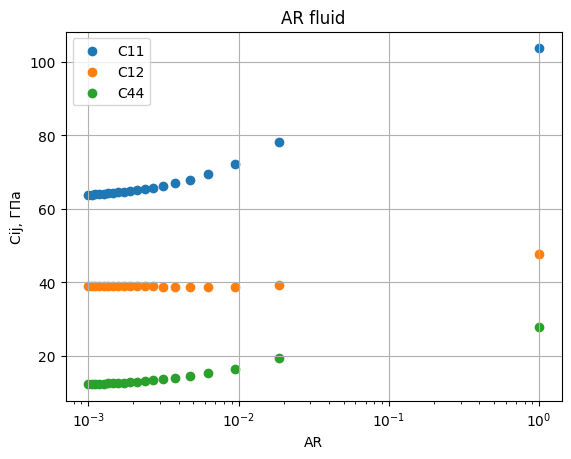

In [ ]:
AR = np.linspace(1, 1000, 20)
plt.scatter(1/AR, c11, label='C11')
plt.scatter(1/AR, c12, label='C12')
plt.scatter(1/AR, c44, label='C44')
plt.xscale("log")
plt.xlabel('AR')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid')

plt.grid()
plt.legend()

In [ ]:
data_gsa = {
    'C11': c11,
    'C12': c12,
    'C44': c44
}

inversion = pd.DataFrame(data_gsa)
inversion['Density (water)'] = data['Density (water)']

density = 2.572247

inversion['Vp air'] = inversion[['C11']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion['Vs air'] = inversion[['C44']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
inversion['AR inclusion'] = 1/np.linspace(1, 1000, 20)

In [ ]:
Vp, Vs = 5.04, 2.36

In [ ]:
inversion['Diff Vp'] = inversion[['Vp air']].apply(lambda x: abs(x[0] - Vp)/Vp*100, axis=1)
inversion['Diff Vs'] = inversion[['Vs air']].apply(lambda x: abs(x[0] - Vs)/Vp*100, axis=1)

In [ ]:
df_sorted = inversion.sort_values(by='Diff Vp')
df_sorted[::-1]

,C11,C12,C44,Density (water),Vp air,Vs air,AR inclusion,Diff Vp,Diff Vs
0,103.604087,47.765372,27.919358,2.572247,6.346468,3.294552,1.000000,25.921989,18.542700
1,78.046280,39.340706,19.352787,2.537162,5.508328,2.742934,0.018664,9.292216,7.597905
2,72.093118,38.834333,16.629392,2.285245,5.294081,2.542622,0.009420,5.041287,3.623459
3,69.447714,38.800219,15.323747,2.326067,5.196042,2.440766,0.006300,3.096069,1.602502
4,67.944779,38.829682,14.557548,2.459785,5.139510,2.378964,0.004732,1.974404,0.376261
5,66.974219,38.866751,14.053734,2.462813,5.102670,2.337435,0.003789,1.243455,0.447720
19,63.752423,39.086300,12.333061,2.346792,4.978426,2.189672,0.001000,1.221716,3.379519
18,63.822338,39.080021,12.371158,2.391097,4.981155,2.193052,0.001055,1.167568,3.312469
17,63.900161,39.073110,12.413526,2.388755,4.984191,2.196804,0.001118,1.107329,3.238023
16,63.987316,39.065465,12.460925,2.463332,4.987588,2.200994,0.001187,1.039912,3.154885


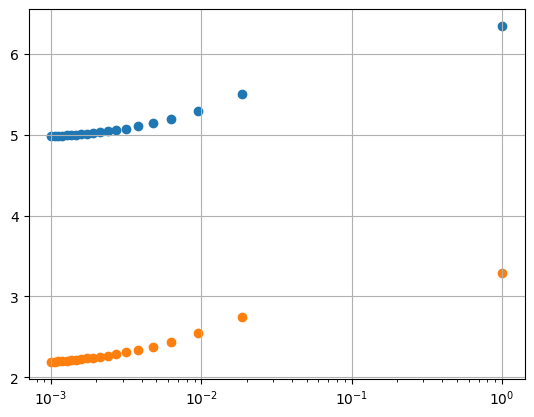

In [ ]:
plt.scatter(inversion['AR inclusion'], inversion['Vp air'])
plt.scatter(inversion['AR inclusion'], inversion['Vs air'])
plt.xscale("log")
plt.grid()

## Rotation by Cij components (full form = triple integration)

$Literature:$
*   Rotation matrix: https://www.continuummechanics.org/rotationmatrix.html
*   Rotation matrix for elastic constants: https://scicomp.stackexchange.com/questions/8093/debugging-a-rotation-matrix-for-elastic-constants (check)
* Paper (best explanation of elastic matrix rotation, check): https://www.researchgate.net/publication/333816845_Mean_elastic_properties_of_isotropic_polycrystals_comparison_between_averaging_approximations_with_numerical_computations

* https://mooseframework.inl.gov/source/materials/ComputeElasticityTensor.html

* The Mathematics of Physical Properties of Crystals (check): https://archive.org/details/bstj22-1-1/page/n57/mode/2up



In [ ]:
def rotation_matrix(theta, phi, psi):

  B_phi = np.array(
      [[np.cos(phi), np.sin(phi), 0], ### <-- Rotation around new axis Z on phi angle
      [-np.sin(phi), np.cos(phi), 0],
      [0, 0, 1]])

  B_theta = np.array([[1, 0, 0], ### <-- Rotation around new axis N on theta angle
           [0, np.cos(theta), np.sin(theta)],
           [0, -np.sin(theta), np.cos(theta)]])

  B_psi = np.array([[np.cos(psi), np.sin(psi), 0], ### <-- Rotation around new axis N on theta angle
           [-np.sin(psi), np.cos(psi), 0],
           [0, 0, 1]])

  return np.linalg.inv(B_phi @ B_theta @ B_psi) # переход из лабораторной системы в XYZ

In [ ]:
def rotation_full(theta, phi, psi, C_lab, index):

  a, b, c ,d = index[0], index[1], index[2], index[3]

  B = rotation_matrix(theta, phi, psi)

  C_rotated = np.zeros((3, 3, 3, 3))

  # Perform the calculation for B_{p,q,m,n}
  for p in range(3):
      for q in range(3):
          for m in range(3):
              for n in range(3):

                for i in range(3):
                    for j in range(3):
                        for k in range(3):
                            for l in range(3):

                                C_rotated[p, q, m, n] +=  B[i,p] * B[j,q] * B[k,m] * B[l,n] * C_lab[i,j,k,l]

  return C_rotated[a, b, c, d]

In [ ]:
def integration_for_rotation(initial_tensor):

  V = 8*np.pi**2

  rotated_tensor = np.zeros((3,3,3,3))

  for i in range(3):
    for j in range(3):
      for k in range(3):
        for l in range(3):

          if initial_tensor[i,j,k,l] < np.abs(10**-10):
            rotated_tensor[i,j,k,l] = 10**-20

          else:


          # if (i==0 and j==0 and k==0 and l==0) or\
          # (i==0 and j==0 and k==1 and l==1) or\
          # (i==1 and j==2 and k==1 and l==2):

            integrand = (lambda theta, phi, psi, i=i, j=j, k=k, l=l: rotation_full(theta, phi, psi, initial_tensor, (i,j,k,l)) * np.sin(theta))

            integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
            rotated_tensor[i,j,k,l] =  integral/V
            print(i+1,j+1, k+1, l+1, rotated_tensor[i,j,k,l])

  #         else:
  #             rotated_tensor[1,1,1,1] = rotated_tensor[0,0,0,0]
  #             rotated_tensor[2,2,2,2] = rotated_tensor[0,0,0,0]

  #             rotated_tensor[0,0,1,1] = rotated_tensor[0,0,1,1]
  #             # rotated_tensor[0,0,2,2] = rotated_tensor[0,0,2,2]
  #             rotated_tensor[1,1,0,0] = rotated_tensor[0,0,1,1]
  #             rotated_tensor[1,1,2,2] = rotated_tensor[0,0,1,1]
  #             rotated_tensor[2,2,0,0] = rotated_tensor[0,0,1,1]
  #             rotated_tensor[2,2,1,1] = rotated_tensor[0,0,1,1]

  #             rotated_tensor[1,2,2,1] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[2,1,2,1] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[1,2,1,2] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[2,1,1,2] = rotated_tensor[1,2,1,2]

  #             rotated_tensor[0,2,2,0] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[2,0,2,0] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[2,0,0,2] = rotated_tensor[1,2,1,2]
  #             # rotated_tensor[1,2,1,2] = rotated_tensor[1,2,1,2]

  #             rotated_tensor[0,1,1,0] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[1,0,1,0] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[1,0,0,1] = rotated_tensor[1,2,1,2]
  #             rotated_tensor[0,1,0,1] = rotated_tensor[1,2,1,2]

  # return rotated_tensor

In [7]:
def izotr(c):

  pi = np.pi
  c_iz = np.zeros((3, 3, 3, 3))

  c11 = c[0, 0, 0, 0]
  c22 = c[1, 1, 1, 1]
  c33 = c[2, 2, 2, 2]
  c12 = c[0, 0, 1, 1]
  c13 = c[0, 0, 2, 2]
  c23 = c[1, 1, 2, 2]
  c44 = c[1, 2, 1, 2]
  c55 = c[0, 2, 0, 2]
  c66 = c[0, 1, 0, 1]

  t1 = 0.3141593E1**2
  t20 = 32.E0/15.E0*c44*t1 + 8.E0/5.E0*c22*t1 + 16.E0/15.E0*c23*t1 + 32.E0/15.E0*c55*t1 + 8.E0/5.E0*c11*t1 + 32.E0/15.E0*c66*t1 + 16.E0/15.E0*c13*t1 + 16.E0/15.E0*c12*t1 + 8.E0/5.E0*c33*t1
  c_iz[0, 0, 0, 0] = t20 / (8 * pi * pi)

  t20 = 32.E0/15.E0*c12*t1 + 8.E0/15.E0*c11*t1 + 8.E0/15.E0*c22*t1 - 16.E0/15.E0*c66*t1 + 32.E0/15.E0*c13*t1 + 32.E0/15.E0*c23*t1 - 16.E0/15.E0*c44*t1 + 8.E0/15.E0*c33*t1 - 16.E0/15.E0*c55*t1
  c_iz[0, 0, 1, 1] = t20 / (8 * pi * pi)
  c_iz[1, 1, 0, 0] = c_iz[0, 0, 1, 1]

  t20 = -8.E0/15.E0*c12*t1 + 8.E0/15.E0*c22*t1 + 8.E0/5.E0*c44*t1 + 8.E0/5.E0*c55*t1 + 8.E0/15.E0*c11*t1 + 8.E0/5.E0*c66*t1 - 8.E0/15.E0*c13*t1 - 8.E0/15.E0*c23*t1 + 8.E0/15.E0*c33*t1
  c_iz[0, 2, 0, 2] = t20 / (8 * pi * pi)

  c_iz[1, 1, 1, 1] = c_iz[0, 0, 0, 0]
  c_iz[2, 2, 2, 2] = c_iz[0, 0, 0, 0]
  c_iz[0, 0, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[1, 1, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 0, 0] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 1, 1] = c_iz[0, 0, 1, 1]
  c_iz[0, 2, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 0, 2] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 2, 1] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 2, 1] = c_iz[0, 2, 0, 2]

  return c_iz

In [ ]:
izotrop(71.883, 71.883, 20.992, 7.17, 3.845, 3.845, 4.576, 4.576, 32.356)

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
9.869604401089358
45.0
46.001733333333334


In [ ]:
BA_eff = izotr(mat2tens(np.round(eff, 3), compl=False))
print(np.round(tens2mat(A_eff, compl=False), 4))


[[46.0017  9.4121  9.4121  0.      0.      0.    ]
 [ 9.4121 46.0017  9.4121  0.      0.      0.    ]
 [ 9.4121  9.4121 46.0017  0.      0.      0.    ]
 [ 0.      0.      0.     18.2948  0.      0.    ]
 [ 0.      0.      0.      0.     18.2948  0.    ]
 [ 0.      0.      0.      0.      0.     18.2948]]


# Переход в тензор без учета размерности

In [ ]:
def effective_tensor_new_A(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  ### -----------

   ### Числитель
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  rslt_num = ((1-porosity)*num_mtrx + porosity*num_fl)

  # for i in range(6):
  #   for j in range(6):
  #     if rslt_num[i,j] <= np.abs(0):
  #       rslt_num[i,j] = 10**-20
  print(f'1st brackets (GPa)')
  print(np.round(rslt_num, 3))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)
  result_fl = (x_fl1 @ g_inv_fl1) * porosity
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)

  # for i in range(6):
  #   for j in range(6):
  #     if rslt_dnmntr[i,j] <= np.abs(0):
  #       rslt_dnmntr[i,j] = 10**-20
  print(f'2nd brackets (1/GPa)')
  print(np.round(rslt_dnmntr, 3))

        ### Effective matrix Cij in laboratory system
  eff_laboratory = rslt_num @ rslt_dnmntr

  for i in range(6):
    for j in range(6):
      if eff_laboratory [i,j] <= np.abs(0):
        eff_laboratory [i,j] = 10**-20
  print(f'Result in laboratory system')
  print(np.round(eff_laboratory, 3))


  #       ### Effective matrix Cij in XYZ system

  A = izotr(mat2tens(rslt_num, compl=False))
  print('A rotated isotropic')
  print(tens2mat(A, compl=False))

  print('B rotated isotropic') # Переход в тензор без учета размерности
  B = izotr(mat2tens(rslt_dnmntr, compl=True))
  print(tens2mat(B, compl=True))

  return eff_laboratory, A, B

In [ ]:
eff, A, B = effective_tensor_new_A(g_matrix, g_fluid, C_mtrx, C_fl, C_c, porosity=0.1)

1st brackets (GPa)
[[72.654  7.854 13.532  0.    -0.     0.   ]
 [ 7.854 72.654 13.532  0.    -0.     0.   ]
 [ 7.854  7.854 78.332  0.    -0.     0.   ]
 [ 0.     0.     0.    32.4   -0.    -0.   ]
 [-0.    -0.    -0.    -0.    32.4   -0.   ]
 [ 0.     0.     0.    -0.    -0.    32.4  ]]
2nd brackets (1/GPa)
[[ 0.999  0.     0.003  0.    -0.    -0.   ]
 [ 0.     0.999  0.003 -0.    -0.    -0.   ]
 [-0.051 -0.051  0.267 -0.     0.    -0.   ]
 [-0.    -0.    -0.     0.141  0.     0.   ]
 [ 0.     0.     0.     0.     0.141  0.   ]
 [-0.    -0.    -0.     0.     0.     0.999]]
Result in laboratory system
[[71.883  7.17   3.845  0.     0.     0.   ]
 [ 7.17  71.883  3.845  0.     0.     0.   ]
 [ 3.845  3.845 20.992  0.     0.     0.   ]
 [ 0.     0.     0.     4.576  0.     0.   ]
 [ 0.     0.     0.     0.     4.576  0.   ]
 [ 0.     0.     0.     0.     0.    32.356]]
[[[[ 7.26544704e+01  3.41686233e-19 -8.36959792e-17]
   [ 3.41686233e-19  7.85447017e+00  1.91896710e-17]
   [-8.369597

In [ ]:
np.round(eff, 3)

array([[71.883,  7.17 ,  3.845,  0.   ,  0.   ,  0.   ],
       [ 7.17 , 71.883,  3.845,  0.   ,  0.   ,  0.   ],
       [ 3.845,  3.845, 20.992,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  4.576,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  4.576,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , 32.356]])

In [ ]:
BA_eff = izotrop(mat2tens(np.round(eff, 3), compl=False))
# print(np.round(tens2mat(A_eff, compl=False), 4))
print(BA_eff[0,0,0,0], BA_eff[0, 0, 1, 1])

[[71.883  7.17   3.845  0.     0.     0.   ]
 [ 7.17  71.883  3.845  0.     0.     0.   ]
 [ 3.845  3.845 20.992  0.     0.     0.   ]
 [ 0.     0.     0.     4.576  0.     0.   ]
 [ 0.     0.     0.     0.     4.576  0.   ]
 [ 0.     0.     0.     0.     0.    32.356]]
9.869604401089358
46.001733333333334
46.001733333333334
46.001733333333334 7.17


In [ ]:
eff

array([[7.25742767e+01, 7.86184161e+00, 3.84476019e+00, 2.99856090e-18,
        2.00352776e-17, 1.28163851e-18],
       [7.86184161e+00, 7.25742767e+01, 3.84476019e+00, 3.57993460e-18,
        2.00352776e-17, 1.28163846e-18],
       [7.84736600e+00, 7.84736600e+00, 2.09918534e+01, 3.57993689e-18,
        1.11464022e-16, 1.28163879e-18],
       [3.24001803e-19, 3.24002918e-19, 3.24006419e-19, 4.57556941e+00,
        9.21513657e-18, 6.17482855e-18],
       [2.74851504e-18, 3.46958579e-18, 5.00011642e-17, 8.95500184e-18,
        4.57556941e+00, 1.09833959e-18],
       [3.24000145e-19, 3.24000099e-19, 3.24000374e-19, 6.16625312e-18,
        1.08976511e-18, 3.23562175e+01]])

In [ ]:
# crack density
AR = 1/100
e = 3*porosity/(4*np.pi*AR)
e

NameError: name 'porosity' is not defined

In [ ]:
c11, c12, c44 = [], [], []
c11_lab, c12_lab, c44_lab = [], [], []

# porosity = np.arange(0.0, 1.1, 0.1)
porosity = 10/100
AR = [1000, 100, 10, 1]

g_matrix = tensor_g(C_c, [1, 1, 1])

for i in AR:
  g_inclusion = tensor_g(C_c, [i, i, 1])
  eff, A, B = effective_tensor_new_A(g_matrix, g_inclusion, C_mtrx, C_fl, C_c, porosity=0.1)

  C_xyz = tens2mat(np.einsum('mnij,mnkl->ijkl', A, B), compl=False)
  C_lab = tens2mat(izotr(mat2tens(eff, compl=False)), compl=False)

  c11.append(C_xyz[0,0])
  c12.append(C_xyz[0,2])
  c44.append(C_xyz[3,3])

  c11_lab.append(C_lab[0,0])
  c12_lab.append(C_lab[0,2])
  c44_lab.append(C_lab[3,3])

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


1st brackets (GPa)
[[72.782  7.982 14.995 -0.    -0.    -0.   ]
 [ 7.982 72.782 14.995 -0.    -0.    -0.   ]
 [ 7.982  7.982 79.795 -0.    -0.    -0.   ]
 [-0.    -0.    -0.    32.4    0.    -0.   ]
 [ 0.     0.     0.     0.    32.4   -0.   ]
 [-0.    -0.    -0.    -0.    -0.    32.4  ]]
2nd brackets (1/GPa)
[[ 1.     0.     0.    -0.     0.     0.   ]
 [ 0.     1.     0.    -0.    -0.     0.   ]
 [-0.057 -0.057  0.229  0.     0.    -0.   ]
 [ 0.     0.     0.     0.016 -0.     0.   ]
 [-0.    -0.    -0.    -0.     0.016  0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]
Result in laboratory system
[[71.924  7.133  3.457  0.     0.     0.   ]
 [ 7.133 71.924  3.457 -0.     0.     0.   ]
 [ 3.457  3.457 18.273  0.     0.    -0.   ]
 [ 0.     0.     0.     0.526 -0.     0.   ]
 [-0.    -0.    -0.    -0.     0.526  0.   ]
 [ 0.     0.     0.     0.     0.    32.396]]
A rotated isotropic
[[76.13217131 12.20242283 12.20242283  0.          0.          0.        ]
 [12.20242283 76.1321713

In [ ]:
c11, c12, c44

([42.01419116063591, 43.16722319686379, 49.51831676759782, 54.923943858491484],
 [16.3964343350299, 15.614339649979776, 13.97716805017755, 13.914512604092074],
 [12.808878412803, 13.776441773441992, 17.770574358710128, 20.50471562719969])

In [ ]:
c11_lab, c12_lab, c44_lab

([43.260199246724795, 46.0481240828856, 58.102743902102844, 66.57335844539564],
 [10.104639763571896, 9.42170444643434, 7.802724317897866, 8.047854600440141],
 [16.57777974157645,
  18.313209818225634,
  25.15000979210249,
  29.262751922477754])

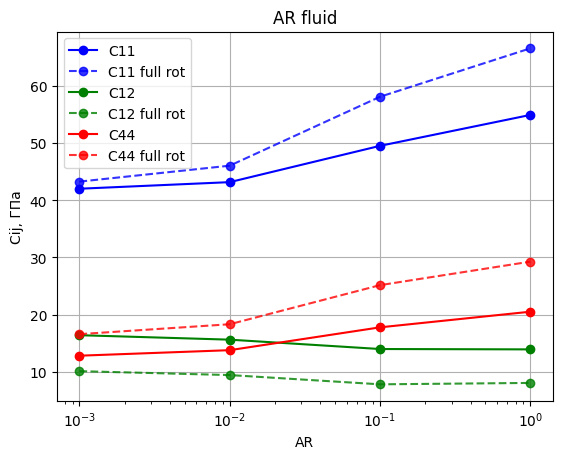

In [ ]:
AR = np.array([1000, 100, 10, 1])

plt.plot(1/AR, c11, label='C11', marker='o', color='blue')
plt.plot(1/AR, c11_lab, label='C11 full rot',  marker='o', linestyle='--', color='blue', alpha=0.8)

plt.plot(1/AR, c12, label='C12', marker='o', color='green')
plt.plot(1/AR, c12_lab, label='C12 full rot',  marker='o', linestyle='--', color='green', alpha=0.8)

plt.plot(1/AR, c44, label='C44', marker='o', color='red')
plt.plot(1/AR, c44_lab, label='C44 full rot',  marker='o', linestyle='--', color='red', alpha=0.8)

plt.xscale("log")
plt.xlabel('AR')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid')

plt.grid()
plt.legend()

In [ ]:
density = 2.572247

for i, j in zip(c11, c44):
  print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

Vp 4.041491491899094 Vs 2.2315119500772225
Vp 4.096573221088479 Vs 2.314260249374384
Vp 4.387595699601878 Vs 2.6284177882832775
Vp 4.620878214079107 Vs 2.8233878444020015


In [ ]:
print(np.sqrt(54/ density), np.sqrt(28 / density))

4.581846602987209 3.2993066393156676


In [ ]:
eff, A, B = effective_tensor_new_A(g_matrix, g_fluid, C_mtrx, C_fl, C_c, porosity=0.1)

1st brackets (GPa)
[[72.654  7.854 13.532  0.    -0.     0.   ]
 [ 7.854 72.654 13.532  0.    -0.     0.   ]
 [ 7.854  7.854 78.332  0.    -0.     0.   ]
 [ 0.     0.     0.    32.4   -0.    -0.   ]
 [-0.    -0.    -0.    -0.    32.4   -0.   ]
 [ 0.     0.     0.    -0.    -0.    32.4  ]]
2nd brackets (1/GPa)
[[ 0.999  0.     0.003  0.    -0.    -0.   ]
 [ 0.     0.999  0.003 -0.    -0.    -0.   ]
 [-0.051 -0.051  0.267 -0.     0.    -0.   ]
 [-0.    -0.    -0.     0.141  0.     0.   ]
 [ 0.     0.     0.     0.     0.141  0.   ]
 [-0.    -0.    -0.     0.     0.     0.999]]
Result in laboratory system
[[71.883  7.17   3.845 -0.     0.    -0.   ]
 [ 7.17  71.883  3.845 -0.     0.    -0.   ]
 [ 3.845  3.845 20.992 -0.     0.    -0.   ]
 [-0.    -0.    -0.     4.576  0.     0.   ]
 [ 0.     0.     0.     0.     4.576  0.   ]
 [-0.    -0.    -0.     0.     0.    32.356]]
A rotated isotropic
[[75.38062971 11.27269148 11.27269148  0.          0.          0.        ]
 [11.27269148 75.3806297

Варианты перемножения тензоров

In [ ]:
C = np.einsum('mnij,mnkl->ijkl', A, B)
np.round(tens2mat(C, compl=False), 4)

array([[43.1672, 15.6143, 15.6143,  0.    ,  0.    ,  0.    ],
       [15.6143, 43.1672, 15.6143,  0.    ,  0.    ,  0.    ],
       [15.6143, 15.6143, 43.1672,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , 13.7764,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , 13.7764,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , 13.7764]])

In [ ]:
C = np.zeros((3,3,3,3))

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):

                for m in range(3):
                    for n in range(3):
                        # for p in range(3):
                        #     for q in range(3):
                        C[i, j, k,l] += A[i, j, m, n] * B[m, n, k, l]
print(np.round(tens2mat(C, compl=False), 4))

[[43.1672 15.6143 15.6143  0.      0.      0.    ]
 [15.6143 43.1672 15.6143  0.      0.      0.    ]
 [15.6143 15.6143 43.1672  0.      0.      0.    ]
 [ 0.      0.      0.     13.7764  0.      0.    ]
 [ 0.      0.      0.      0.     13.7764  0.    ]
 [ 0.      0.      0.      0.      0.     13.7764]]


In [ ]:
C = torch.matmul(torch.from_numpy(A), torch.from_numpy(B))
CC = C.numpy()
print(np.round(tens2mat(CC, compl=False), 4))

[[40.6878  1.2397  1.2397  0.      0.      0.    ]
 [ 1.2397 40.6878  1.2397  0.      0.      0.    ]
 [ 1.2397  1.2397 40.6878  0.      0.      0.    ]
 [ 0.      6.8882  6.8882  0.      0.      0.    ]
 [ 6.8882  0.      6.8882  0.      0.      0.    ]
 [ 6.8882  6.8882  0.      0.      0.      0.    ]]


In [ ]:
A_eff = izotr(mat2tens(eff, compl=False))
print(np.round(tens2mat(A_eff, compl=False), 4))

[[46.0481  9.4217  9.4217  0.      0.      0.    ]
 [ 9.4217 46.0481  9.4217  0.      0.      0.    ]
 [ 9.4217  9.4217 46.0481  0.      0.      0.    ]
 [ 0.      0.      0.     18.3132  0.      0.    ]
 [ 0.      0.      0.      0.     18.3132  0.    ]
 [ 0.      0.      0.      0.      0.     18.3132]]


# Переход в тензор с учетом размерности с использованием тензора g

In [ ]:
def effective_tensor_new_test(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  ### -----------

   ### Числитель
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  rslt_num = ((1-porosity)*num_mtrx + porosity*num_fl)

  for i in range(6):
    for j in range(6):
      if rslt_num[i,j] <= np.abs(0):
        rslt_num[i,j] = 10**-20

  print(f'1st brackets (GPa)')
  print(np.round(rslt_num, 3))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)
  result_fl = (x_fl1 @ g_inv_fl1) * porosity
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)

  for i in range(6):
    for j in range(6):
      if rslt_dnmntr[i,j] <= np.abs(0):
        rslt_dnmntr[i,j] = 10**-20

  print(f'2nd brackets (1/GPa)')
  print(np.round(rslt_dnmntr, 3))

        ### Effective matrix Cij in laboratory system
  eff_laboratory = rslt_num @ rslt_dnmntr
  print(f'Result in laboratory system')
  print(np.round(eff_laboratory, 3))


  #       ### Effective matrix Cij in XYZ system

  A = izotr(mat2tens(rslt_num, compl=False))
  print('A rotated isotropic')
  print(tens2mat(A, compl=False))


  print('B rotated isotropic') #переход в тензор с учетом размерности с использованием тензора g
  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ rslt_dnmntr, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b)
  print(B)
  return eff_laboratory, A, B

### новый правильный варинат расчетов

In [8]:
def effective_tensor_new_fluid(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  num_fl_rotated = izotr(mat2tens(num_fl, compl=False))
  ### -----------


  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*tens2mat(num_fl_rotated, compl=False))

  # for i in range(6):
  #   for j in range(6):
  #     if rslt_num[i,j] <= np.abs(0):
  #       rslt_num[i,j] = 10**-20

  print(f'1st brackets (GPa)')
  print(np.round(rslt_num, 3))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity) # matrix shape

  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  print('B rotated isotropic') #переход в тензор с учетом размерности с использованием тензора g
  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ result_fl, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b) # tensor shape

  aa = mat2tens(np.linalg.inv(g_matrix), compl=False)
  bb = tens2mat(np.einsum('ijmn,nmkl->ijkl', aa, B), compl=False)

  result_fl_rotated = g_matrix @ bb


  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl_rotated)

  # for i in range(6):
  #   for j in range(6):
  #     if rslt_dnmntr[i,j] <= np.abs(0):
        # rslt_dnmntr[i,j] = 10**-20

  print(f'2nd brackets (1/GPa)')
  print(np.round(rslt_dnmntr, 3))

        ### Effective matrix Cij in laboratory system
  eff_laboratory = rslt_num @ rslt_dnmntr
  print(f'Result in laboratory system')
  print(np.round(eff_laboratory, 3))


  # #       ### Effective matrix Cij in XYZ system

  # A = izotr(mat2tens(rslt_num, compl=False))
  # print('A rotated isotropic')
  # print(tens2mat(A, compl=False))


  # print('B rotated isotropic') #переход в тензор с учетом размерности с использованием тензора g
  # g_matrix = (tens2mat(g_m, compl=True))
  # M = mat2tens(np.linalg.inv(g_matrix) @ rslt_dnmntr, compl=False)
  # b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  # B = izotr(b)
  # print(B)
  return eff_laboratory

In [ ]:
g_fluid_01 = tensor_g(C_c, [10, 10, 1])

In [9]:
eff= effective_tensor_new_fluid(g_matrix, g_fluid, C_mtrx, C_fl, C_c, porosity=0.1)

1st brackets (GPa)
[[76.055 12.19  12.19   0.    -0.     0.   ]
 [12.19  76.055 12.19   0.    -0.    -0.   ]
 [12.19  12.19  76.055  0.     0.    -0.   ]
 [-0.     0.    -0.    31.932  0.    -0.   ]
 [ 0.     0.     0.     0.    31.932 -0.   ]
 [-0.    -0.     0.     0.    -0.    31.932]]
B rotated isotropic
2nd brackets (1/GPa)
[[ 0.183  0.144  0.144  0.    -0.    -0.   ]
 [ 0.144  0.183  0.144  0.    -0.    -0.   ]
 [ 0.144  0.144  0.183  0.    -0.    -0.   ]
 [ 0.     0.     0.     0.039 -0.     0.   ]
 [-0.    -0.    -0.     0.     0.039  0.   ]
 [ 0.     0.     0.    -0.    -0.     0.039]]
Result in laboratory system
[[17.443 14.959 14.959  0.    -0.    -0.   ]
 [14.959 17.443 14.959  0.    -0.    -0.   ]
 [14.959 14.959 17.443  0.    -0.    -0.   ]
 [ 0.     0.     0.     1.242 -0.    -0.   ]
 [-0.    -0.    -0.     0.     1.242  0.   ]
 [-0.    -0.    -0.     0.    -0.     1.242]]


In [ ]:
0.001 Result in laboratory system
[[17.443 14.959 14.959  0.    -0.    -0.   ]
 [14.959 17.443 14.959  0.    -0.    -0.   ]
 [14.959 14.959 17.443  0.    -0.    -0.   ]
 [ 0.     0.     0.     1.242 -0.    -0.   ]
 [-0.    -0.    -0.     0.     1.242  0.   ]
 [-0.    -0.    -0.     0.    -0.     1.242]]

0.01 Result in laboratory system
[[28.418 11.566 11.566  0.    -0.     0.   ]
 [11.566 28.418 11.566  0.    -0.     0.   ]
 [11.566 11.566 28.418  0.    -0.     0.   ]
 [-0.     0.    -0.     8.426 -0.    -0.   ]
 [ 0.     0.     0.    -0.     8.426 -0.   ]
 [ 0.    -0.     0.     0.    -0.     8.426]]

 0.1 Result in laboratory system
[[54.686  8.228  8.228  0.    -0.     0.   ]
 [ 8.228 54.686  8.228  0.    -0.     0.   ]
 [ 8.228  8.228 54.686 -0.     0.    -0.   ]
 [-0.     0.     0.    23.229 -0.    -0.   ]
 [ 0.    -0.     0.     0.    23.229  0.   ]
 [-0.    -0.     0.     0.     0.    23.229]]

 1. Result in laboratory system
[[66.506  8.04   8.04   0.    -0.     0.   ]
 [ 8.04  66.506  8.04   0.    -0.    -0.   ]
 [ 8.04   8.04  66.506 -0.    -0.    -0.   ]
 [-0.     0.    -0.    29.233 -0.    -0.   ]
 [-0.     0.     0.     0.    29.233  0.   ]
 [ 0.    -0.     0.     0.    -0.    29.233]]

SyntaxError: invalid syntax (<ipython-input-13-4bde35d289a8>, line 1)

In [ ]:
# g_matrix = tensor_g(C_c, [1, 1, 1])
# g_inclusion = tensor_g(C_c, [100, 100, 1])

In [ ]:
# g_inclusion = tensor_g(C_c, [100, 100, 1])

In [ ]:
# g_inclusion = tensor_g(C_c, [1000, 1000, 1])

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [ ]:
np.round(eff, 2)

array([[72.57,  7.86,  3.84,  0.  ,  0.  ,  0.  ],
       [ 7.86, 72.57,  3.84,  0.  ,  0.  ,  0.  ],
       [ 7.85,  7.85, 20.99,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  4.58,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  4.58,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 32.36]])

In [ ]:
A_eff = izotr(mat2tens(np.round(eff, 2), compl=False))
print(np.round(tens2mat(A_eff, compl=False), 4))

[[46.37    9.6833  9.6833  0.      0.      0.    ]
 [ 9.6833 46.37    9.6833  0.      0.      0.    ]
 [ 9.6833  9.6833 46.37    0.      0.      0.    ]
 [ 0.      0.      0.     18.3433  0.      0.    ]
 [ 0.      0.      0.      0.     18.3433  0.    ]
 [ 0.      0.      0.      0.      0.     18.3433]]


In [ ]:
tens2mat(C_mtrx, compl=False)

array([[80.,  8.,  8.,  0.,  0.,  0.],
       [ 8., 80.,  8.,  0.,  0.,  0.],
       [ 8.,  8., 80.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 36.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 36.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 36.]])

In [ ]:
eff, A, B = effective_tensor_new_test(g_matrix, g_fluid, C_mtrx, C_fl, C_c, porosity=0.1)

1st brackets (GPa)
[[72.654  7.854 13.532  0.     0.     0.   ]
 [ 7.854 72.654 13.532  0.     0.     0.   ]
 [ 7.854  7.854 78.332  0.     0.     0.   ]
 [ 0.     0.     0.    32.4    0.     0.   ]
 [ 0.     0.     0.     0.    32.4    0.   ]
 [ 0.     0.     0.     0.     0.    32.4  ]]
2nd brackets (1/GPa)
[[0.999 0.    0.003 0.    0.    0.   ]
 [0.    0.999 0.003 0.    0.    0.   ]
 [0.    0.    0.267 0.    0.    0.   ]
 [0.    0.    0.    0.141 0.    0.   ]
 [0.    0.    0.    0.    0.141 0.   ]
 [0.    0.    0.    0.    0.    0.999]]
Result in laboratory system
[[72.574  7.862  3.845  0.     0.     0.   ]
 [ 7.862 72.574  3.845  0.     0.     0.   ]
 [ 7.847  7.847 20.992  0.     0.     0.   ]
 [ 0.     0.     0.     4.576  0.     0.   ]
 [ 0.     0.     0.     0.     4.576  0.   ]
 [ 0.     0.     0.     0.     0.    32.356]]
A rotated isotropic
[[75.30421955 11.26126483 11.26126483  0.          0.          0.        ]
 [11.26126483 75.30421955 11.26126483  0.          0.       

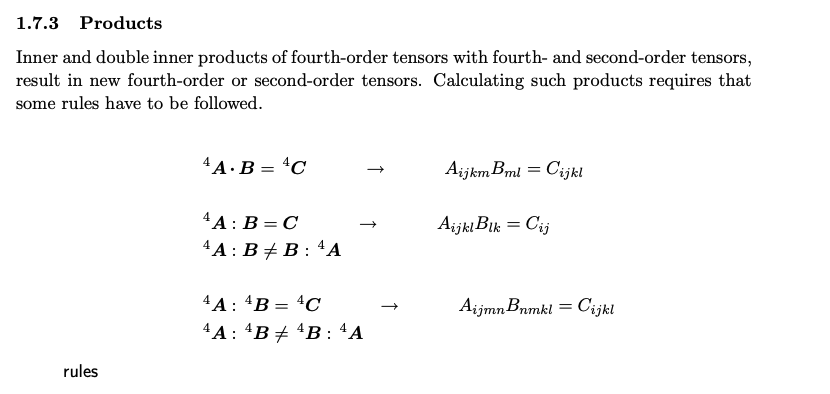

http://pajarito.materials.cmu.edu/documents/VectTensColMat.pdf

In [ ]:
C = np.einsum('ijmn,nmkl->ijkl', A, B)
np.round(tens2mat(C, compl=False), 4)

array([[48.5494, 12.8479, 12.8479,  0.    ,  0.    ,  0.    ],
       [12.8479, 48.5494, 12.8479,  0.    ,  0.    ,  0.    ],
       [12.8479, 12.8479, 48.5494,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , 17.8508,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , 17.8508,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , 17.8508]])

In [ ]:
c11, c12, c44 = [], [], []
c11_lab, c12_lab, c44_lab = [], [], []

porosity = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

for i in porosity:
  eff, A, B = effective_tensor_new_A(g_matrix, g_inclusion, C_mtrx, C_fl, C_c, porosity=i)

  C_xyz = tens2mat(np.einsum('ijmn,mnkl->ijkl', A, B), compl=False)
  C_lab = tens2mat(izotr(mat2tens(eff, compl=False)), compl=False)

  c11.append(C_xyz[0,0])
  c12.append(C_xyz[0,2])
  c44.append(C_xyz[3,3])

  c11_lab.append(C_lab[0,0])
  c12_lab.append(C_lab[0,2])
  c44_lab.append(C_lab[3,3])

NameError: name 'g_inclusion' is not defined

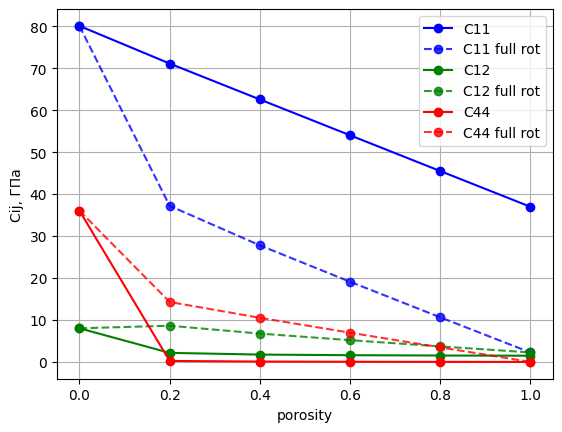

In [ ]:
x = porosity

plt.plot(x, c11, label='C11', marker='o', color='blue')
plt.plot(x, c11_lab, label='C11 full rot',  marker='o', linestyle='--', color='blue', alpha=0.8)

plt.plot(x, c12, label='C12', marker='o', color='green')
plt.plot(x, c12_lab, label='C12 full rot',  marker='o', linestyle='--', color='green', alpha=0.8)

plt.plot(x, c44, label='C44', marker='o', color='red')
plt.plot(x, c44_lab, label='C44 full rot',  marker='o', linestyle='--', color='red', alpha=0.8)

# plt.xscale("log")
plt.xlabel('porosity')
plt.ylabel('Cij, ГПа')
# plt.title ('AR fluid')

plt.grid()
plt.legend()